# Expansion Factor Exploratory Analysis
***
## Selecting Intersection Candidates

Our intersection segments of interest are

* Front/Bathurst to Front/Spadina
* King/Yonge to King/Jarvis
* King/University to King/Yonge

<br>
These were chosen as candidates because: 

* Data for these segments exist in the `bluetooth` and `miovision` schema 
* The distances are relatively short
* There are few places of interest down these segments
* There are few streets to turn on, so the volume from the starting point to the ending point is assumably relatively consistent  

In [53]:
# import relevant modules
import configparser
from psycopg2 import connect
import psycopg2.sql as pg
import pandas.io.sql as pandasql
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np
import statsmodels.api as sm
import pandas as pd 
from statsmodels.formula.api import ols
pd.options.display.mpl_style = 'default'


C:\Users\alouis2\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2862: FutureWarning: 
mpl_style had been deprecated and will be removed in a future version.
Use `matplotlib.pyplot.style.use` instead.

  exec(code_obj, self.user_global_ns, self.user_ns)


In [54]:
# connect to database
CONFIG = configparser.ConfigParser()
CONFIG.read(r'C:\Users\alouis2\Documents\Python Scripts\db.cfg')
dbset = CONFIG['DBSETTINGS']
con = connect(**dbset)

 The SQL query below grabs volume data from November 1st to November 8th. The query exccludes any missing data points in this time frame. Only Lights, Single-Unit Trucks, and Articulated Trucks were counted.   
 
 <br>
 The `formatter` function simply substitutes intersection id's in to a multiline query string so 3 massive strings don't need to be assigned to variables. 

In [55]:
string = '''with missing_dates as (select distinct(datetime_bin) from 
                (select intersection_uid, datetime_bin, leg, dir, sum(volume) from miovision.volumes_15min
                where (intersection_uid = %d and leg = 'W' and dir = 'EB' 
                and datetime_bin::date >= '2017-11-01' and datetime_bin::date <= '2017-11-08' 
                and classification_uid in (1,4,5))
                group by intersection_uid, datetime_bin, leg, dir
                order by intersection_uid, datetime_bin) f
                EXCEPT
                select distinct(datetime_bin) from 
                (select intersection_uid, datetime_bin, leg, dir, sum(volume) from miovision.volumes_15min
                where (intersection_uid = %d  and leg = 'E' and dir = 'EB' 
                and datetime_bin::date >= '2017-11-01' and datetime_bin::date <= '2017-11-08' 
                and classification_uid in (1,4,5))
                group by intersection_uid, datetime_bin, leg, dir
                order by intersection_uid, datetime_bin) f)

                select intersection_uid, datetime_bin, leg, dir, sum(volume) from miovision.volumes_15min
                where (intersection_uid = %d  and leg = 'E' and dir = 'EB' 
                and datetime_bin::date >= '2017-11-01' and datetime_bin::date <= '2017-11-08' and datetime_bin not in (select * from missing_dates)
                and classification_uid in (1,4,5)) or 

                (intersection_uid = %d  and leg = 'W' and dir = 'EB' 
                and datetime_bin::date >= '2017-11-01' and datetime_bin::date <= '2017-11-08' and datetime_bin not in (select * from missing_dates)
                and classification_uid in (1,4,5))

                group by intersection_uid, datetime_bin, leg, dir
                order by intersection_uid, datetime_bin; '''


def formatter(string, int1, int2):
    return string % (int2, int1, int1, int2)

#formatter(string, 5, 6)

#frontnew = pandasql.read_sql(pg.SQL(formatter(string,5,6)), con)

front = pandasql.read_sql(pg.SQL(formatter(string,5,6)), con)
king1 = pandasql.read_sql(pg.SQL(formatter(string,18,20)), con)
king2 = pandasql.read_sql(pg.SQL(formatter(string,15,18)), con)



Separate each intersection into individual dataframes. 

In [56]:
front5 = pd.DataFrame(front.loc[i,] for i in range(len(front)) if front.loc[i,]['intersection_uid'] == 5)
front6 = pd.DataFrame(front.loc[i,] for i in range(len(front)) if front.loc[i,]['intersection_uid'] == 6)
king15 = pd.DataFrame(king2.loc[i,] for i in range(len(king2)) if king2.loc[i,]['intersection_uid'] == 15)
king182 = pd.DataFrame(king2.loc[i,] for i in range(len(king2)) if king2.loc[i,]['intersection_uid'] == 18)
king181 = pd.DataFrame(king1.loc[i,] for i in range(len(king1)) if king1.loc[i,]['intersection_uid'] == 18)
king20 = pd.DataFrame(king1.loc[i,] for i in range(len(king1)) if king1.loc[i,]['intersection_uid'] == 20)

Below are plots of the beginning of the segments (red) compared against the end of the segments (blue). If the through volume is consistent, red and blue lines should greatly overlap. 

It can be seen that for each graph, there is great overlap with some noise for each intersection. 

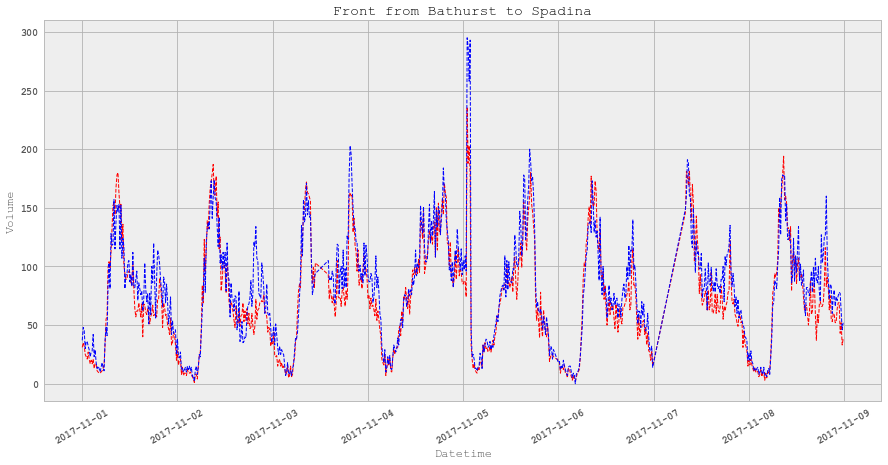

C:\Users\alouis2\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\font_manager.py:1316: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


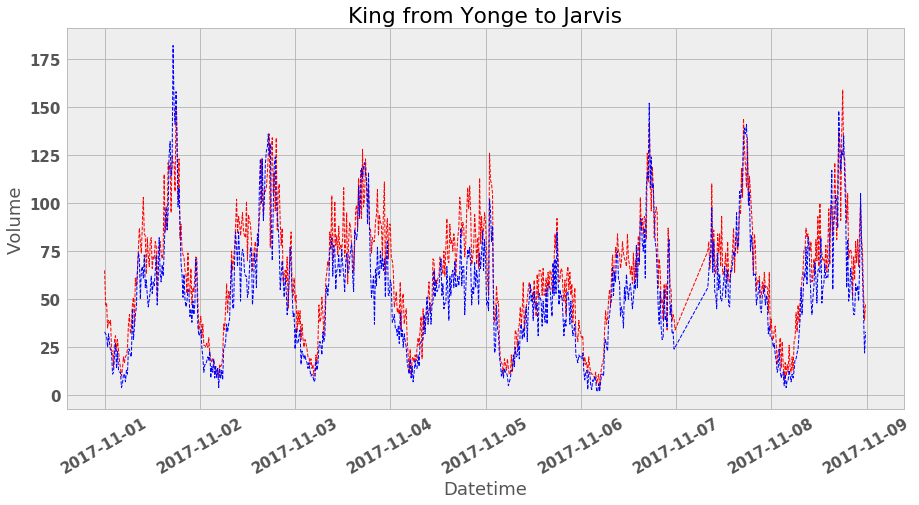

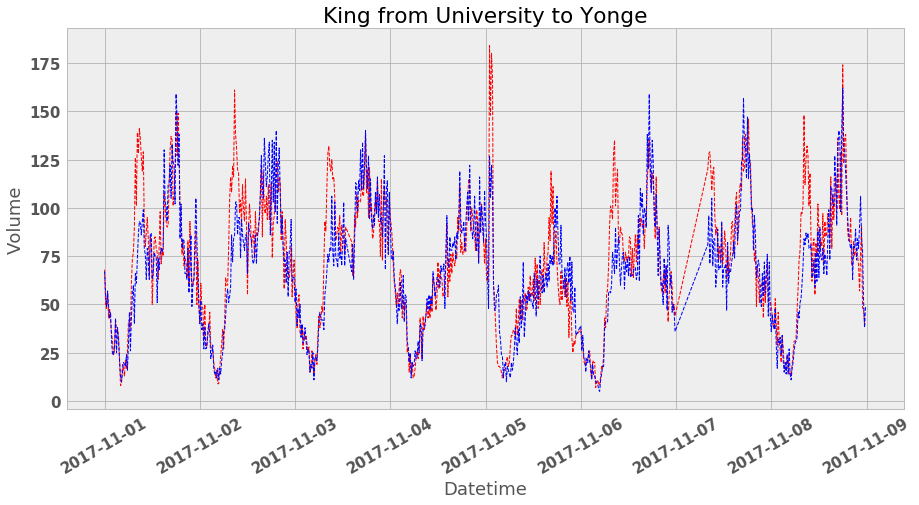

In [57]:
plt.figure(figsize = (15,7))
plt.plot(front5['datetime_bin'], front5['sum'], 'r--', front6['datetime_bin'], front6['sum'], 'b--')
plt.title('Front from Bathurst to Spadina')
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}
plt.rc('font', **font)
plt.ylabel('Volume')
plt.xlabel('Datetime')
plt.xticks(rotation = 30)
#plt.axes().get_xaxis().set_ticks([])

plt.figure(figsize = (15,7))
plt.plot(king181['datetime_bin'], king181['sum'], 'r--', king20['datetime_bin'], king20['sum'], 'b--')
plt.title('King from Yonge to Jarvis')
plt.rc('font', **font)
plt.ylabel('Volume')
plt.xlabel('Datetime')
plt.xticks(rotation = 30)
#plt.axes().get_xaxis().set_ticks([])


plt.figure(figsize = (15,7))
plt.plot(king15['datetime_bin'], king15['sum'], 'r--', king182['datetime_bin'], king182['sum'], 'b--')
plt.title('King from University to Yonge')
plt.rc('font', **font)
plt.ylabel('Volume')
plt.xlabel('Datetime')
plt.xticks(rotation = 30)
#plt.axes().get_xaxis().set_ticks([])


plt.show()

For each segment, the beginning and ending volumes are subtracted, squared, and summated, to give a sort of residual metric we can compare the segments against. It can be seen that King from Yonge to Jarvis has the lowest value, indicating the best volume consistency. However, take note that this data came just before the King Street pilot, and we wish to minimize noise as much as possible. 

In [58]:
((front6.reset_index(drop = True)['sum'].subtract(front5.reset_index(drop = True)['sum']))**2).sum(),((king20.reset_index(drop = True)['sum'].subtract(king181.reset_index(drop = True)['sum']))**2).sum(), ((king182.reset_index(drop = True)['sum'].subtract(king15.reset_index(drop = True)['sum']))**2).sum()

(244345.0, 191591.0, 241779.25)

Below are scatter plots for each segment, where the beginning point volumes are compared to ending point volumes. If the volumes are very consistent, the scatter plot should follow closely along the line $y = x$. It can be seen that the first and second plot do this quite well. 

C:\Users\alouis2\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\font_manager.py:1316: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


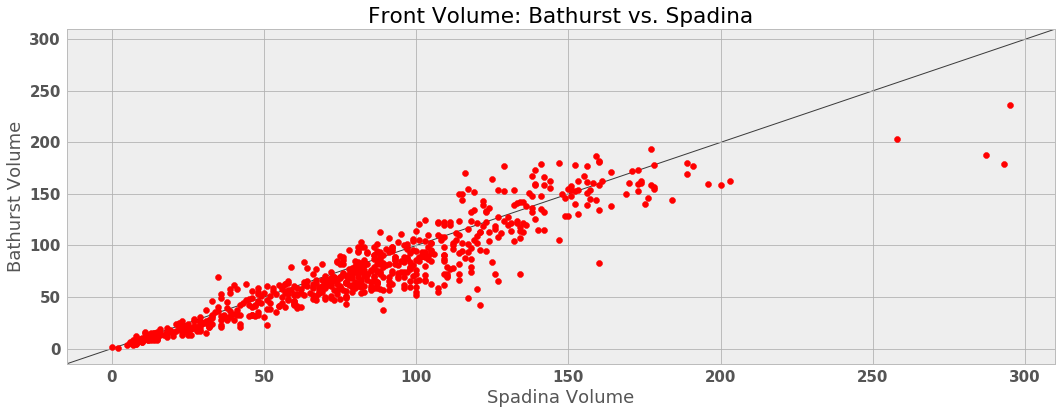

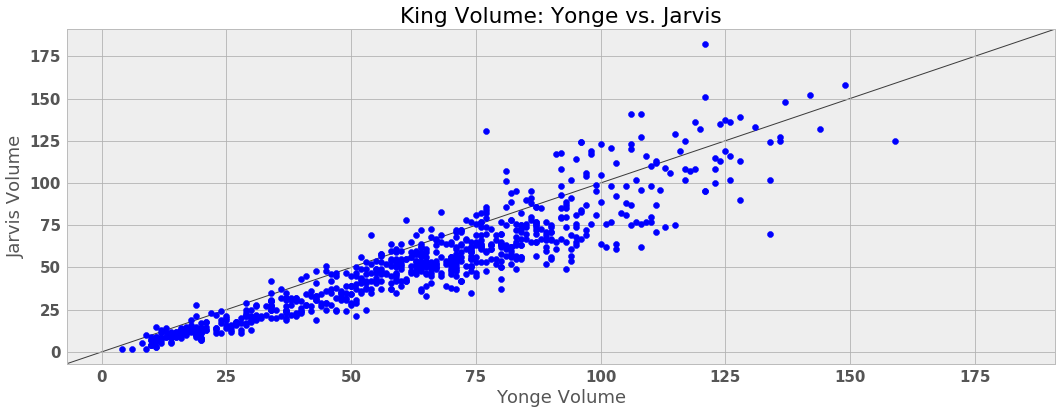

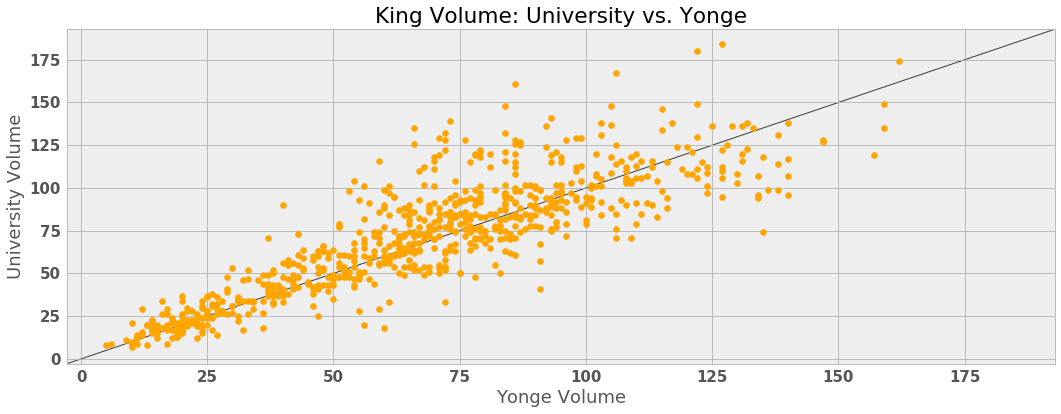

In [59]:
fig, ax = plt.subplots()
ax.scatter(front6.reset_index(drop = True)['sum'], front5.reset_index(drop = True)['sum'], c = 'red')
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

plt.title('Front Volume: Bathurst vs. Spadina')
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_xlim(lims)
ax.set_ylim(lims)
fig.set_figheight(6)
fig.set_figwidth(15)
plt.rc('font', **font)
plt.ylabel('Bathurst Volume')
plt.xlabel('Spadina Volume')
plt.tight_layout()

fig, ax = plt.subplots()
ax.scatter(king181.reset_index(drop = True)['sum'], king20.reset_index(drop = True)['sum'], c = 'blue')
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  
    np.max([ax.get_xlim(), ax.get_ylim()]),  
]

# now plot both limits against eachother
plt.title('King Volume: Yonge vs. Jarvis')
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_xlim(lims)
ax.set_ylim(lims)
fig.set_figheight(6)
fig.set_figwidth(15)
plt.rc('font', **font)
plt.ylabel('Jarvis Volume')
plt.xlabel('Yonge Volume')
plt.tight_layout()


fig, ax = plt.subplots()
ax.scatter(king182.reset_index(drop = True)['sum'], king15.reset_index(drop = True)['sum'], c = 'orange')
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  
    np.max([ax.get_xlim(), ax.get_ylim()]),  
]

plt.title('King Volume: University vs. Yonge')
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_xlim(lims)
ax.set_ylim(lims)
fig.set_figheight(6)
fig.set_figwidth(15)
plt.rc('font', **font)
plt.ylabel('University Volume')
plt.xlabel('Yonge Volume')
plt.tight_layout()

plt.show()


From the above, Front seems like the best plot. For the other two, notice how as the volume increases, so does the variance/noise. 



For this reason, we choose Front St. from Bathurst to Spadina. It seems like the volume data is quite consistent. Moreover, we arbitrarily choose Front/Spadina as our intersection of interest for volume measurement. 











## Analyzing Front/Spadina 
***

We read in our sql file.We then create a dataframe called `frontbt` containing volume and bluetooth data. 

In [60]:
query = open('btandvols_front.sql', 'r',  encoding='utf-8-sig')

frontbt = pd.read_sql_query(query.read(),con)

frontbt

,datetime_bin,obs,volume
0,2017-11-01 00:15:00,2,48.0
1,2017-11-01 00:30:00,2,45.0
2,2017-11-01 01:00:00,1,36.0
3,2017-11-01 01:15:00,3,36.0
4,2017-11-01 01:30:00,2,32.0
5,2017-11-01 01:45:00,1,29.0
6,2017-11-01 02:15:00,1,27.0
7,2017-11-01 02:30:00,1,28.0
8,2017-11-01 02:45:00,2,42.0
9,2017-11-01 03:00:00,1,23.0


Let's plot the bluetooth and volume data and look for any patterns.


C:\Users\alouis2\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\font_manager.py:1316: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


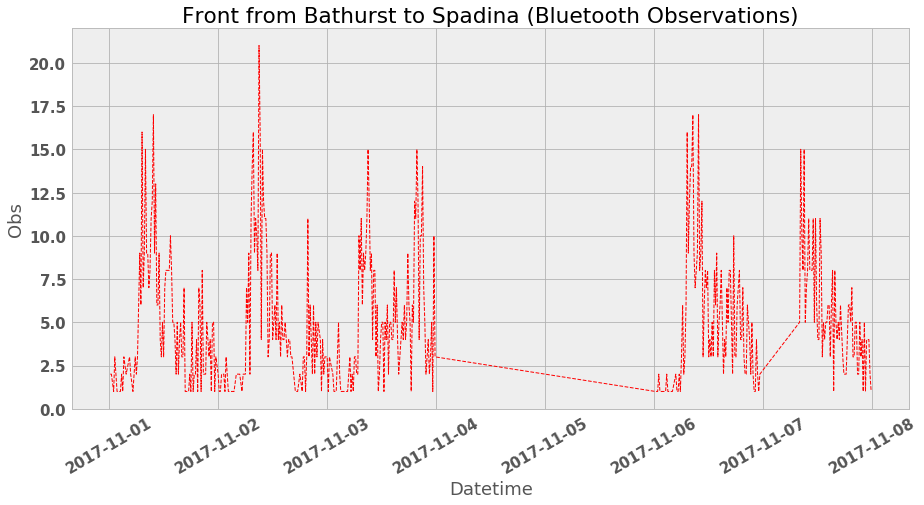

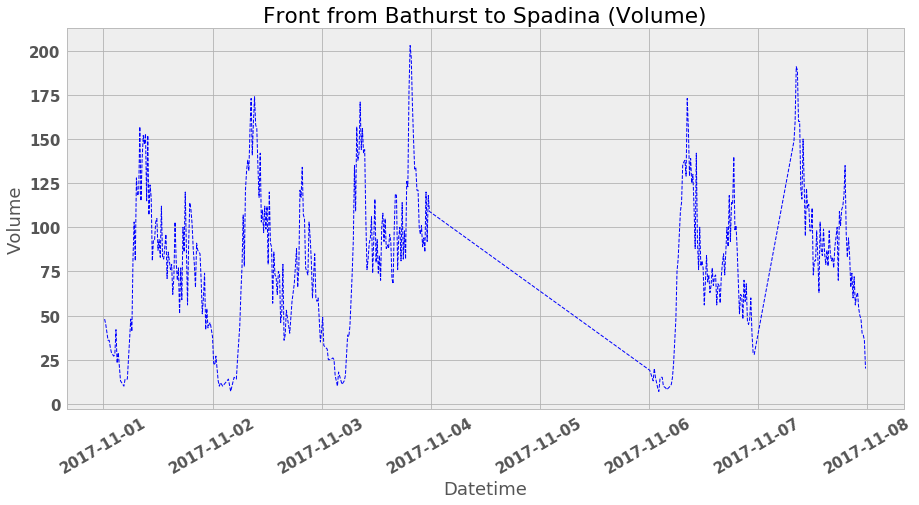

In [61]:
plt.figure(figsize = (15,7))
plt.plot(frontbt['datetime_bin'], frontbt['obs'],'r--')
plt.title('Front from Bathurst to Spadina (Bluetooth Observations)')
plt.rc('font', **font)
plt.xticks(rotation = 30)
plt.ylabel('Obs')
plt.xlabel('Datetime')
#plt.axes().get_xaxis().set_ticks([])

plt.figure(figsize = (15,7))
plt.plot(frontbt['datetime_bin'], frontbt['volume'], 'b--')
plt.title('Front from Bathurst to Spadina (Volume)')
plt.rc('font', **font)
plt.xticks(rotation = 30)
plt.ylabel('Volume')
plt.xlabel('Datetime')
#plt.axes().get_xaxis().set_ticks([])



plt.show()

As seen above, the data is relatively similar on different scales. Notice how volume peaks and valleys occur during bluetooth peaks and valleys. 


We perform a regression on the data. We ignore the intercept value, as we hypothesize the volume data is a scaled version of the bluetooth data, i.e. an expansion factor is at play. The formula is as follows:

$Volume = a*Obs$

Where a is a scaling factor. 

In [62]:
fit = ols("volume ~ obs + 0", data=frontbt).fit()

The summary below indicates that the factor is extremely significant. Moreover, an R-squared value of 0.833 tells us that 83% of the variation in Volume can be explained by our scaling factor model. 

In [63]:
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 volume   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     2003.
Date:                Tue, 06 Feb 2018   Prob (F-statistic):          3.16e-158
Time:                        10:25:22   Log-Likelihood:                -2034.0
No. Observations:                 403   AIC:                             4070.
Df Residuals:                     402   BIC:                             4074.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
obs           13.2742      0.297     44.750      0.000      12.691      13.857
==============================================================================
Omnibus:                        7.439   Durbin-Watson:                   1.348
Prob(Omnibus):                  0.024   Jarque-Bera (JB):                9.219
Skew:                          -0.183   Prob(JB):                      0.00996
Kurtosis:                       3.644   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We summarize our findings graphically with the plots below. 

C:\Users\alouis2\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\font_manager.py:1316: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


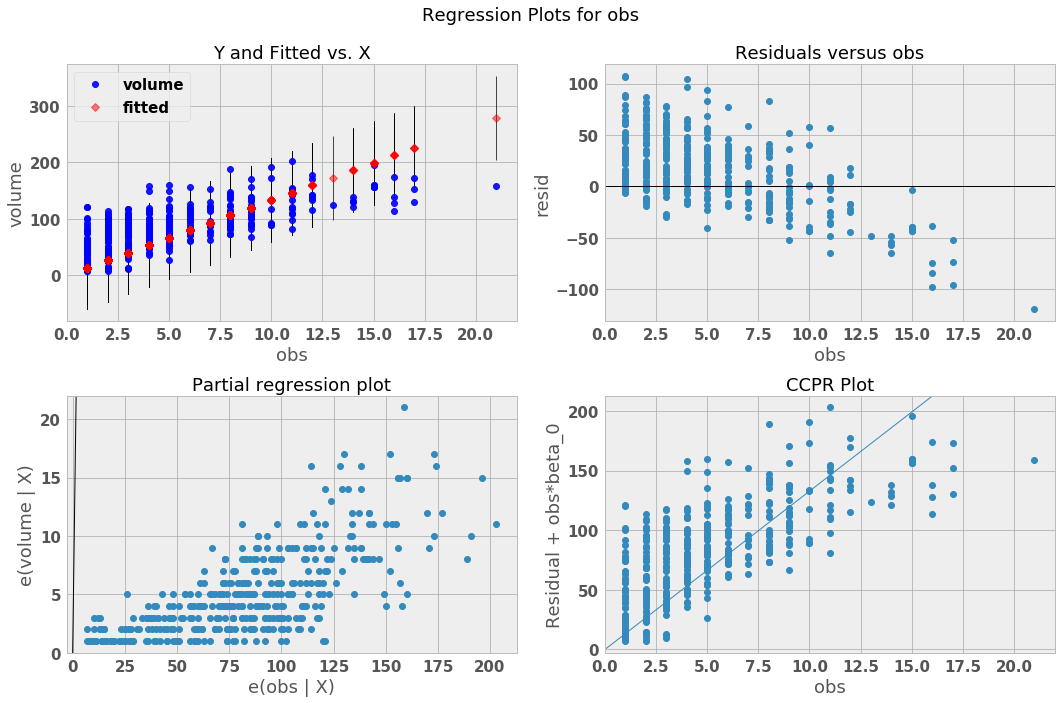

In [64]:
fig = plt.figure(figsize=(15,10))
fig = sm.graphics.plot_regress_exog(fit, "obs", fig=fig)
plt.show()

Taking a look at the plots above (particularly the residuals plot), it can be seen that initially the fit works pretty decently. However, bluetooth observation values increase, the residuals get larger. This implies that the scaling factor works poorly as a predictor as observation counts increase. 


Let's investigate this further. If we divide each volume value by observation value, we will obtain a scaling factor for every datapoint. To do this, we simply divide the two dataframes. 

C:\Users\alouis2\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\font_manager.py:1316: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


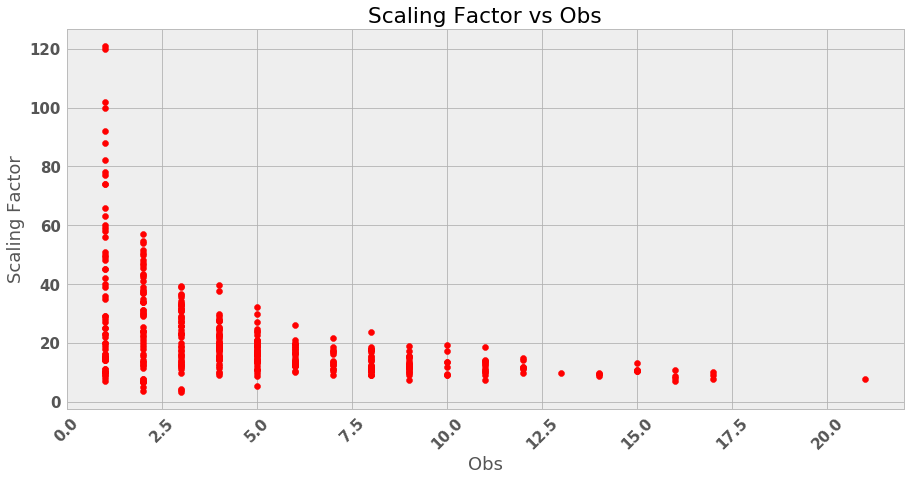

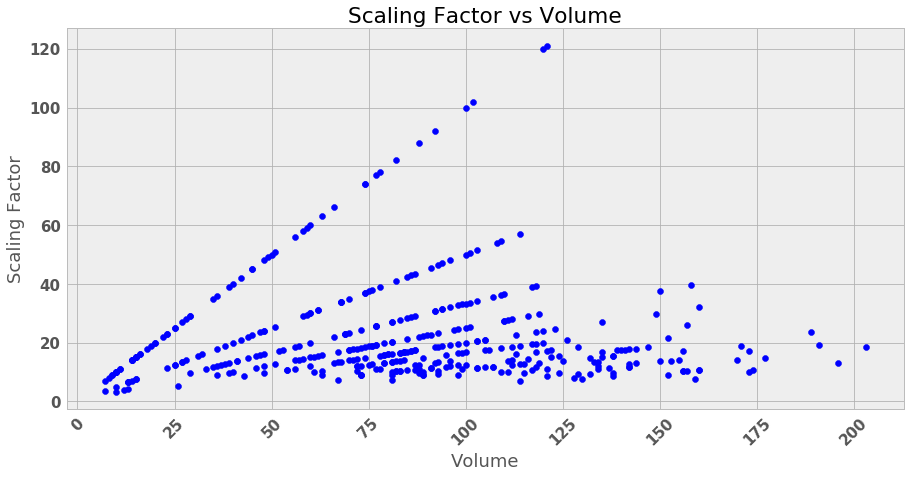

In [65]:
scales = frontbt['volume']/frontbt['obs']

plt.figure(figsize = (15,7))
plt.scatter(frontbt['obs'], scales, c = 'red')
plt.xlabel('Obs')
plt.ylabel('Scaling Factor')
plt.title('Scaling Factor vs Obs')
plt.rc('font', **font)
#plt.axes().get_xaxis().set_ticks([])
plt.xticks(rotation = 45)

plt.figure(figsize = (15,7))
plt.scatter(frontbt['volume'], scales, c = 'blue')
plt.xlabel('Volume')
plt.ylabel('Scaling Factor')
plt.title('Scaling Factor vs Volume')
plt.rc('font', **font)
#plt.axes().get_xaxis().set_ticks([])
plt.xticks(rotation = 45)

plt.show()

It seems like there is an exponential decay of the scaling factor as observations increase. However, notice that there is more data for lower observation values vs. higher observation values. 
Moreover, consider the following scenario:

Assume that observation values are totally random. Irrespective of what the observation values are, greater volume values will always give a greater scaling factor. This fact needs to be taken into consideration in this exploratory analysis. Let's look at a boxplot for scale values categorized by observations. 

C:\Users\alouis2\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2862: FutureWarning: 
mpl_style had been deprecated and will be removed in a future version.
Use `matplotlib.pyplot.style.use` instead.

  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\alouis2\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


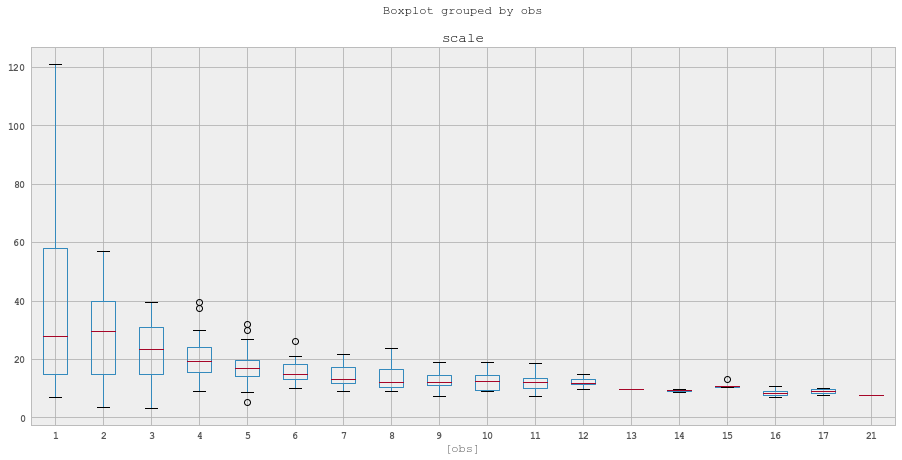

In [66]:
frontbt['scale'] = scales
ov = frontbt.loc[:, ['scale', 'obs']]

pd.options.display.mpl_style = 'default'
ov.boxplot(by = 'obs', figsize = (15,7))
plt.show()

The above results are much more detailed than the simple scale vs obs graph we had earlier. The number of datapoints decreases drastically overtime. Moreover, look at the median scale value for each obs category. The median decreases much more slowly, and as obs values increase, the median also becomes much more varied. 

<br>
Let's aggregate the observations and volume data by 30 mins to reduce noise. 

## 30 Minute Aggregation 
***

We create a new SQL file to aggregate by 30 minutes. This is simply done by changing the group by clause and utilizing the `date_trunc` function. 

In [67]:
query = open('front_30minagg.sql', 'r',  encoding='utf-8-sig')

frontbt = pd.read_sql_query(query.read(),con)

frontbt.head(10)

,datetime_bin,obs,volume
0,2017-11-01 00:00:00,2,85.0
1,2017-11-01 00:30:00,2,75.0
2,2017-11-01 01:00:00,4,72.0
3,2017-11-01 01:30:00,3,61.0
4,2017-11-01 02:00:00,1,50.0
5,2017-11-01 02:30:00,3,70.0
6,2017-11-01 03:00:00,4,52.0
7,2017-11-01 03:30:00,2,31.0
8,2017-11-01 04:30:00,5,24.0
9,2017-11-01 05:00:00,1,32.0


First, lets graph observations and volumes. Evidently the graphs are smoother and peaks and valleys can be better seen. The general pattern of the volume data (i.e. peaks and valleys) carries over much better to observations when compared ot 15 minute aggregation. 

C:\Users\alouis2\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\font_manager.py:1316: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


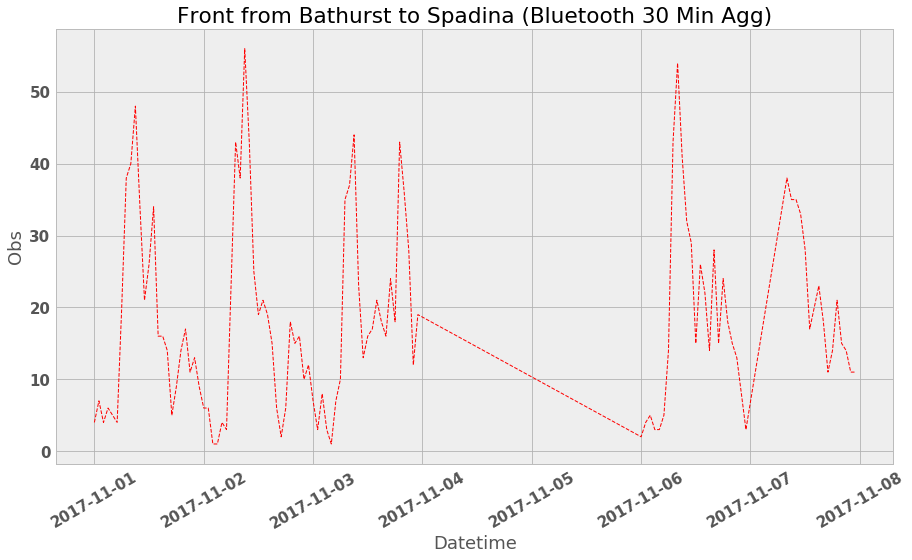

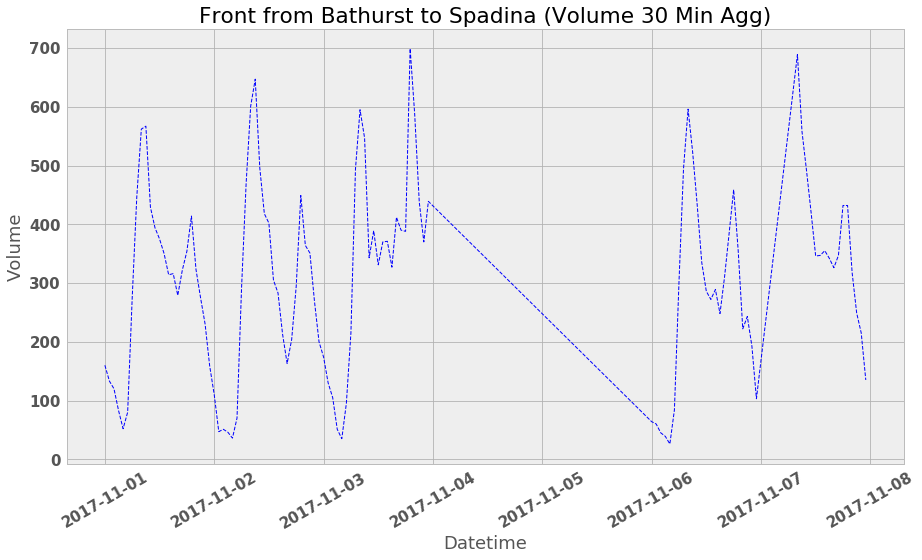

In [87]:
plt.figure(figsize = (15,8))
plt.plot(frontbt['datetime_bin'], frontbt['obs'],'r--')
plt.title('Front from Bathurst to Spadina (Bluetooth 30 Min Agg)')
plt.xlabel('Datetime')
plt.ylabel('Obs')
plt.rc('font', **font)
plt.xticks(rotation = 30)


plt.figure(figsize = (15,8))
plt.plot(frontbt['datetime_bin'], frontbt['volume'], 'b--')
plt.title('Front from Bathurst to Spadina (Volume 30 Min Agg)')
plt.xlabel('Datetime')
plt.ylabel('Volume')
plt.rc('font', **font)
plt.xticks(rotation = 30)

plt.show()

We fit the data using the same model as before. Notice how the R-Squared value improved by almost 6%. The p-value is still great. Our obs coefficient increased as well, i.e. the scaling factor is bigger. 

In [69]:
fit = ols("volume ~ obs + 0", data=frontbt).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 volume   R-squared:                       0.880
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                     1590.
Date:                Tue, 06 Feb 2018   Prob (F-statistic):          7.52e-102
Time:                        10:25:29   Log-Likelihood:                -1207.0
No. Observations:                 218   AIC:                             2416.
Df Residuals:                     217   BIC:                             2419.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
obs           14.2177      0.357     39.880      0.000      13.515      14.920
==============================================================================
Omnibus:                       15.019   Durbin-Watson:                   1.292
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               19.516
Skew:                          -0.489   Prob(JB):                     5.78e-05
Kurtosis:                       4.092   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Now we summarize our regression via plots. These plots are much better than 15 minute aggregation. Notice how while there is still a downward trend in the residuals for larger obs values, the overall trend is much more straight. 

C:\Users\alouis2\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\font_manager.py:1316: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


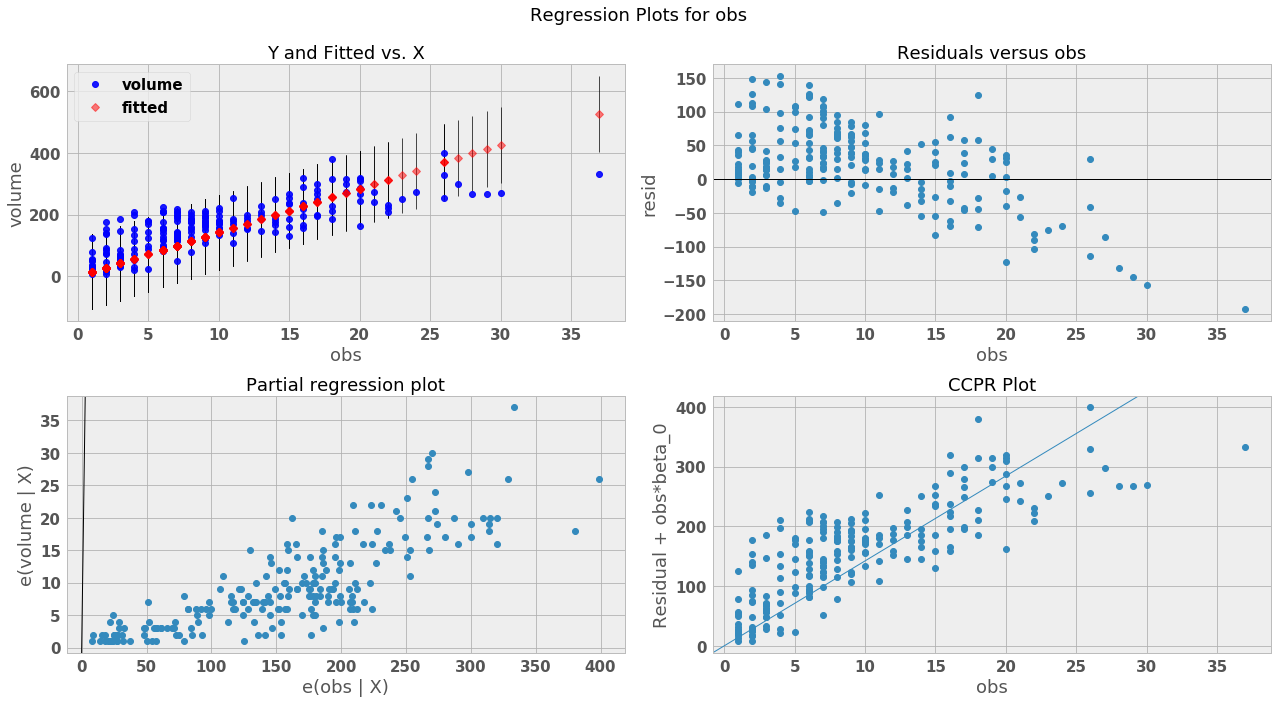

In [70]:
fig = plt.figure(figsize=(18,10))
fig = sm.graphics.plot_regress_exog(fit, "obs", fig=fig)
plt.show()

Now we graph scales. Notice how for the scaling factor vs obs graph, there is less noise in the beginning due to our 30 minute aggregation. Unfortunately, for the volume graph, there are still clear separated linear trends. 

C:\Users\alouis2\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\font_manager.py:1316: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


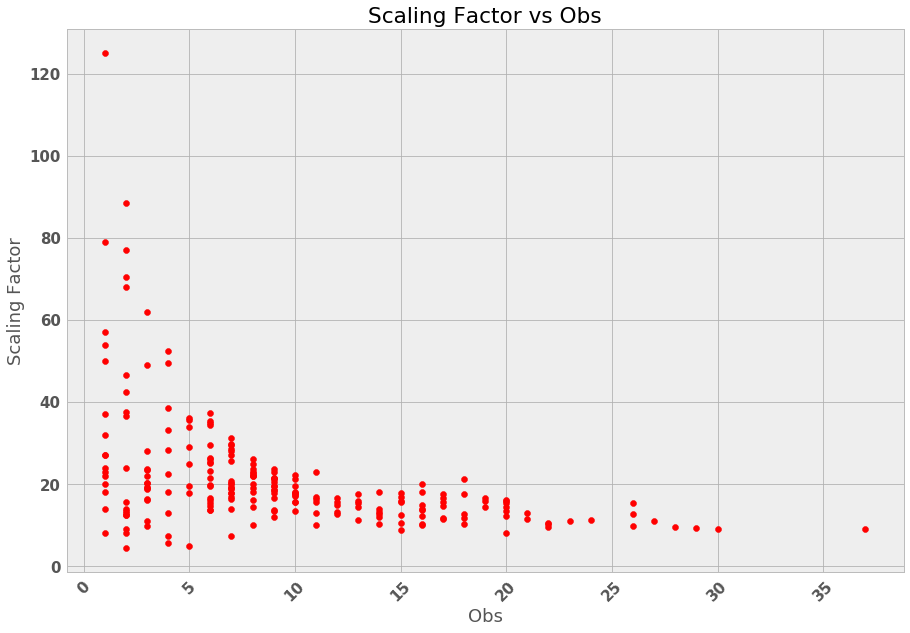

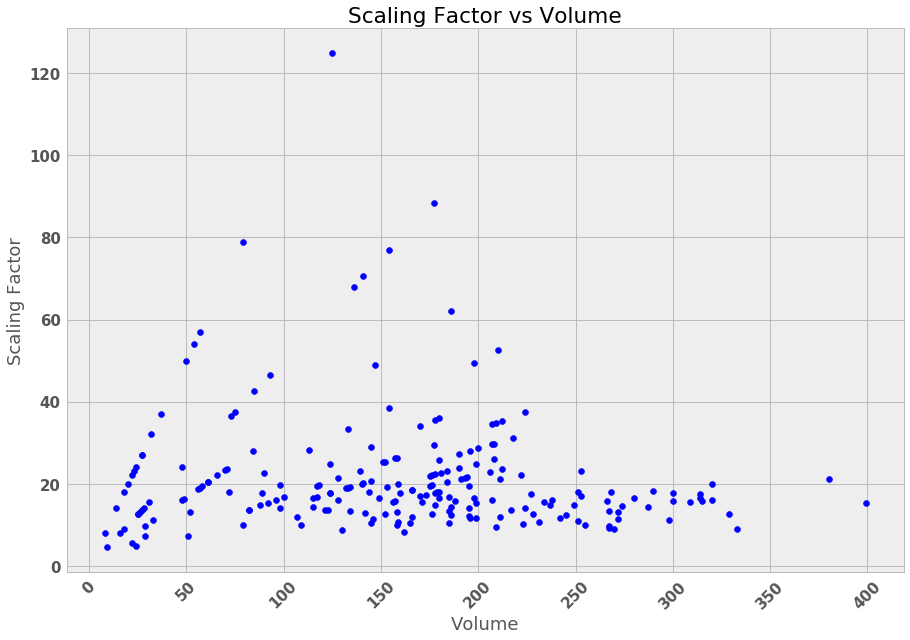

In [71]:
scales = frontbt['volume']/frontbt['obs']

plt.figure(figsize = (15,10))
plt.scatter(frontbt['obs'], scales, c = 'red')
plt.title('Scaling Factor vs Obs')
plt.ylabel('Scaling Factor')
plt.xlabel('Obs')
plt.rc('font', **font)
plt.xticks(rotation = 45)

plt.figure(figsize = (15,10))
plt.scatter(frontbt['volume'], scales, c = 'blue')
plt.title('Scaling Factor vs Volume')
plt.ylabel('Scaling Factor')
plt.xlabel('Volume')
plt.rc('font', **font)
plt.xticks(rotation = 45)

plt.show()

Now for the boxplot. Notice how the medians are much more random. There is less of an indication of exponential decay here. 

C:\Users\alouis2\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2862: FutureWarning: 
mpl_style had been deprecated and will be removed in a future version.
Use `matplotlib.pyplot.style.use` instead.

  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\alouis2\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


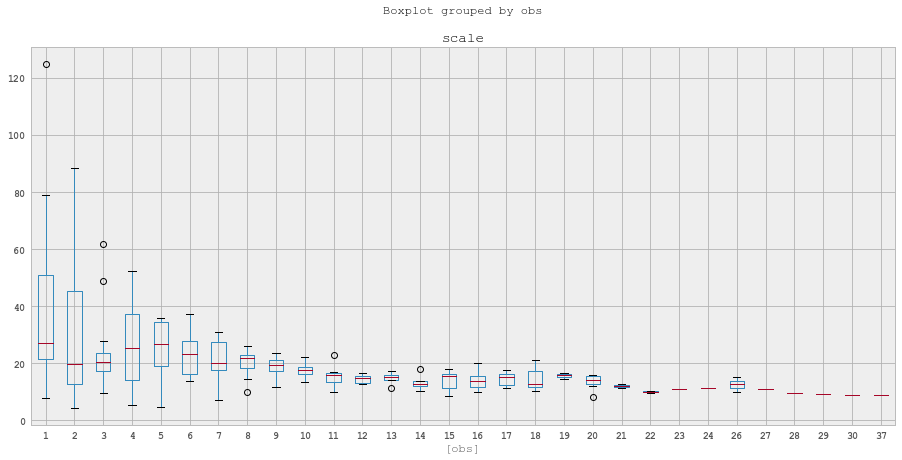

In [72]:
frontbt['scale'] = scales
ov = frontbt.loc[:, ['scale', 'obs']]
pd.options.display.mpl_style = 'default'
ov.boxplot(by = 'obs', figsize = (15,7))
plt.show()

The results and analysis for 30 minute aggregation were decisively better than 15 minute aggregation. Hourly aggregation should be even better. 

Note that as our intervals for aggregation increase, our data points decrease. However, for hourly aggregation, there will be enough data to make statistical conclusions. 

## Hourly Aggregation 
***

To even further reduce noise, we aggregate by the hour. 

In [73]:
query = open('front_hourlyagg.sql', 'r',  encoding='utf-8-sig')

frontbt = pd.read_sql_query(query.read(),con)

frontbt.head(10)

,datetime_bin,obs,volume
0,2017-11-01 00:00:00,4,160.0
1,2017-11-01 01:00:00,7,133.0
2,2017-11-01 02:00:00,4,120.0
3,2017-11-01 03:00:00,6,83.0
4,2017-11-01 04:00:00,5,52.0
5,2017-11-01 05:00:00,4,80.0
6,2017-11-01 06:00:00,20,275.0
7,2017-11-01 07:00:00,38,446.0
8,2017-11-01 08:00:00,40,562.0
9,2017-11-01 09:00:00,48,567.0


C:\Users\alouis2\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\font_manager.py:1316: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


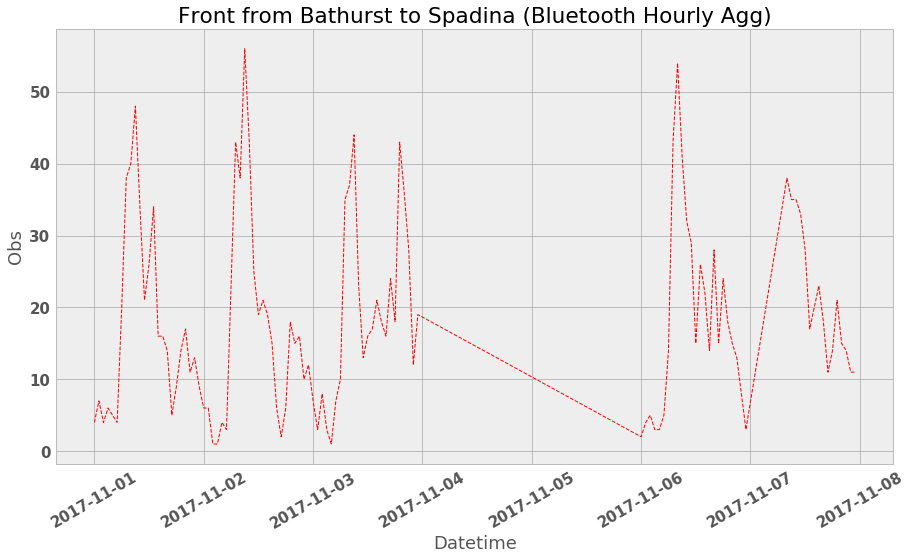

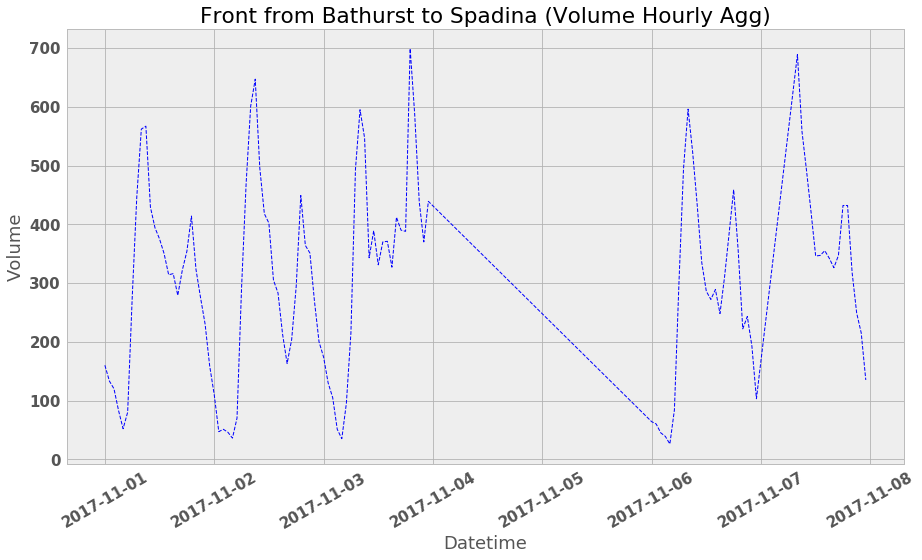

In [86]:
plt.figure(figsize = (15,8))
plt.plot(frontbt['datetime_bin'], frontbt['obs'],'r--')
plt.title('Front from Bathurst to Spadina (Bluetooth Hourly Agg)')
plt.xlabel('Datetime')
plt.ylabel('Obs')
plt.rc('font', **font)
plt.xticks(rotation = 30)

plt.figure(figsize = (15,8))
plt.plot(frontbt['datetime_bin'], frontbt['volume'], 'b--')
plt.title('Front from Bathurst to Spadina (Volume Hourly Agg)')
plt.xlabel('Datetime')
plt.ylabel('Volume')
plt.rc('font', **font)
plt.xticks(rotation = 30)

plt.show()

The plots above look better than 30 minute and 15 minute aggregation. We perform a regression to get our scaling factor. 

In [75]:
fit = ols("volume ~ obs + 0", data=frontbt).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 volume   R-squared:                       0.919
Model:                            OLS   Adj. R-squared:                  0.919
Method:                 Least Squares   F-statistic:                     1267.
Date:                Tue, 06 Feb 2018   Prob (F-statistic):           1.55e-62
Time:                        10:25:37   Log-Likelihood:                -673.46
No. Observations:                 112   AIC:                             1349.
Df Residuals:                     111   BIC:                             1352.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
obs           14.8423      0.417     35.589      0.000      14.016      15.669
==============================================================================
Omnibus:                        0.724   Durbin-Watson:                   0.911
Prob(Omnibus):                  0.696   Jarque-Bera (JB):                0.534
Skew:                          -0.169   Prob(JB):                        0.766
Kurtosis:                       3.027   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Evidently our scaling factor gets larger and larger because aggregation produces greater volumes. Notice the R-squared value. This R value is the best amongst the 3 different aggregations. We plot the residuals.

C:\Users\alouis2\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\font_manager.py:1316: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


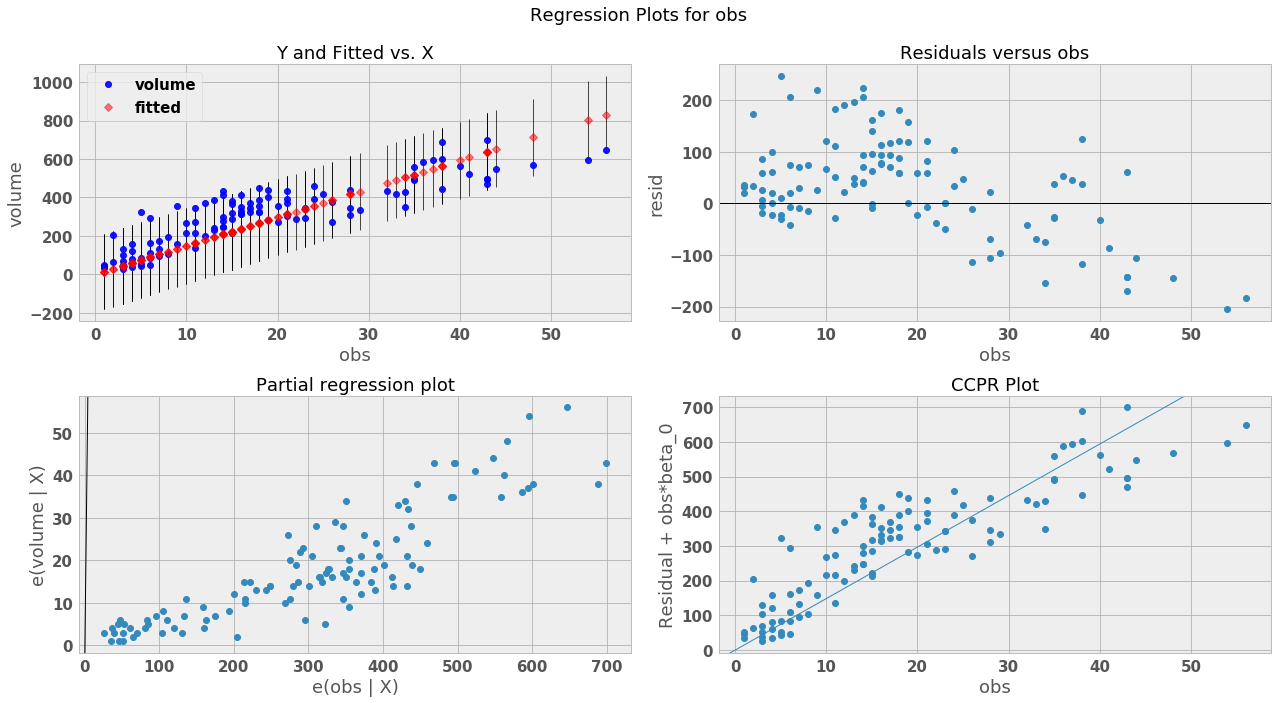

In [76]:
fig = plt.figure(figsize=(18,10))
fig = sm.graphics.plot_regress_exog(fit, "obs", fig=fig)
plt.show()

The residuals fall to same problem as the previous two scale factor models. As observation values increase, the prediction becomes poorer and poorer. Although there are fewer data points for larger values, this still seems to be a trend that occurs for larger values. 

C:\Users\alouis2\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\font_manager.py:1316: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


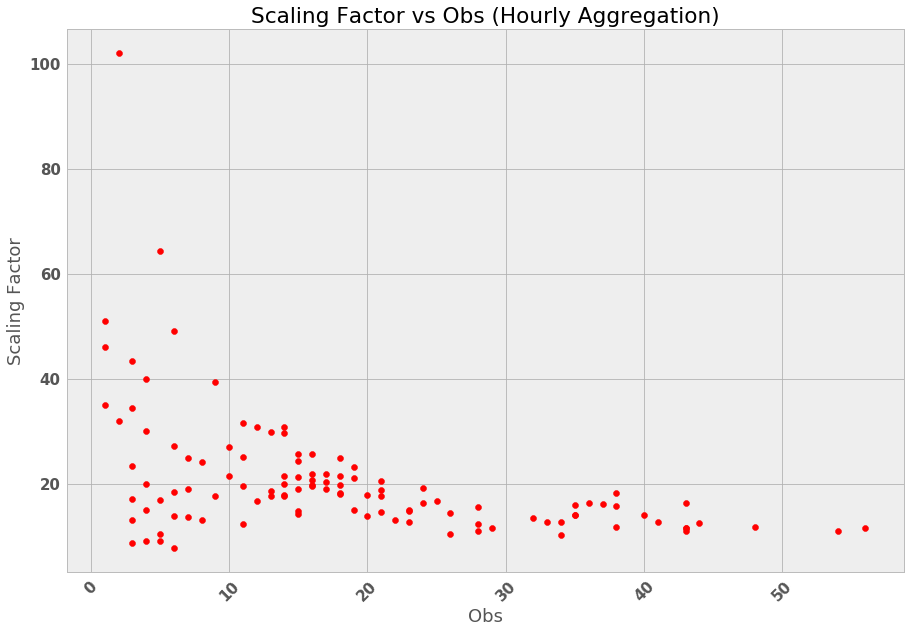

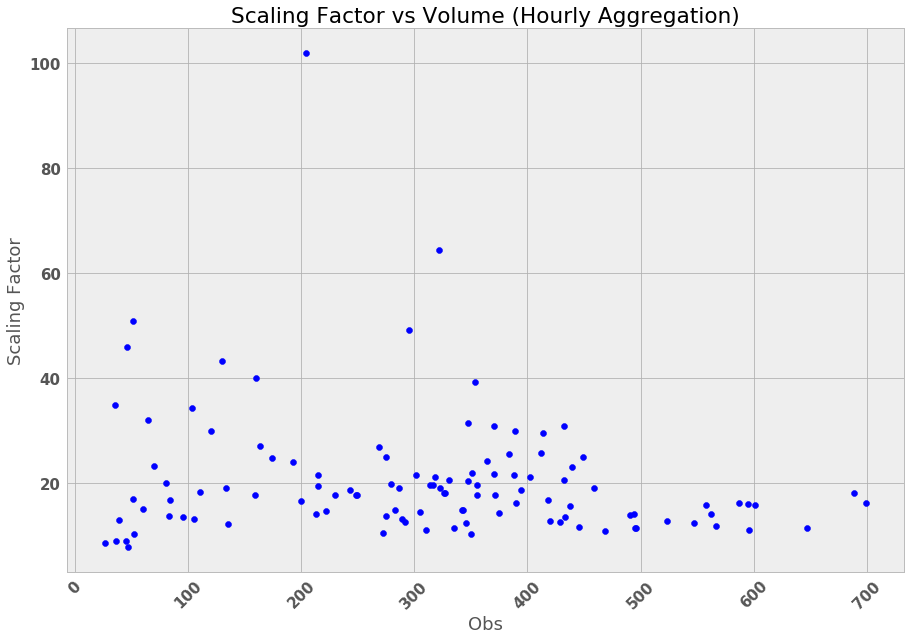

In [77]:
scales = frontbt['volume']/frontbt['obs']

plt.figure(figsize = (15,10))
plt.scatter(frontbt['obs'], scales, c = 'red')
plt.title('Scaling Factor vs Obs (Hourly Aggregation)')
plt.xlabel('Obs')
plt.ylabel('Scaling Factor')
plt.rc('font', **font)
plt.xticks(rotation = 45)

plt.figure(figsize = (15,10))
plt.scatter(frontbt['volume'], scales, c = 'blue')
plt.xlabel('Obs')
plt.ylabel('Scaling Factor')
plt.title('Scaling Factor vs Volume (Hourly Aggregation)')
plt.rc('font', **font)
plt.xticks(rotation = 45)

plt.show()

Now we graph scales. Notice how for the scaling factor vs obs graph, there is less noise due to our hourly aggregation. Moreover, the linear trends for scaling factor vs volume cannot be detected. 

C:\Users\alouis2\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2862: FutureWarning: 
mpl_style had been deprecated and will be removed in a future version.
Use `matplotlib.pyplot.style.use` instead.

  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\alouis2\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


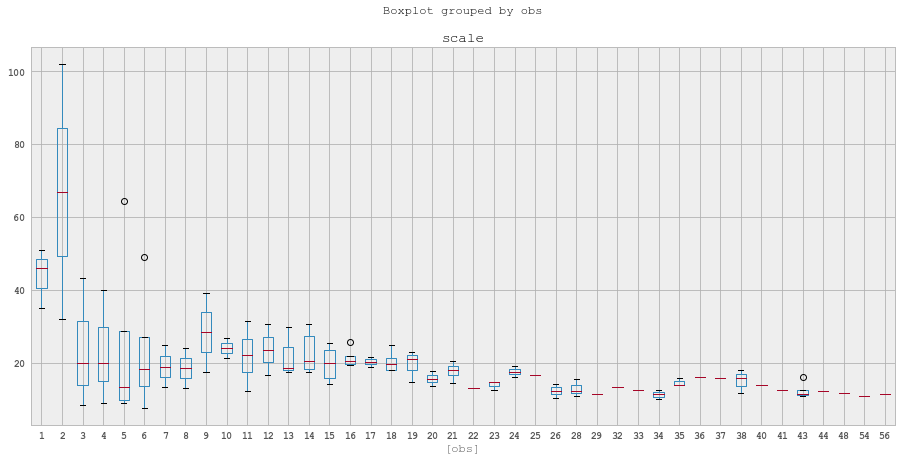

In [78]:
frontbt['scale'] = scales
ov = frontbt.loc[:, ['scale', 'obs']]

pd.options.display.mpl_style = 'default'
ov.boxplot(by = 'obs', figsize = (15,7))
plt.show()

Now for the boxplot. The values are even more random than the 30 minute aggregation. 

## Adelaide Hourly 
***

We wish to further investigate the fact that for high bluetooth observation values, our scale factor works poorer and poorer as a predictor. However, for front street, we have less large bluetooth obersvation values. For Adelaide going Eastbound from Bathurst to Spadina, there are more higher bluetooth observation values. So we analyze this street to see what the scale factor is still poor. 

In [79]:
string = '''select bt.hourly as datetime_bin, bt.obs, mio.volume  from (
            select intersection_uid, date_trunc('hour', datetime_bin) as hourly, leg, dir, sum(volume) as volume from miovision.volumes_15min
            where (intersection_uid = 2  and leg = 'W' and dir = 'EB' and datetime_bin::date in ('2017-12-04', '2017-12-05', '2017-12-06','2017-12-07','2017-12-08')
            and classification_uid in (1,4,5))

            group by intersection_uid, hourly, leg, dir) mio, 

            (select date_trunc('hour', datetime_bin) as hourly, sum(obs) as obs from bluetooth.aggr_15min
            where analysis_id = 1453959
            group by hourly) bt

            where mio.hourly = bt.hourly;'''

adelaide = pandasql.read_sql(pg.SQL(string), con)

In [80]:
adelaide.head(15)

,datetime_bin,obs,volume
0,2017-12-04 00:00:00,7,201.0
1,2017-12-04 01:00:00,5,161.0
2,2017-12-04 02:00:00,3,147.0
3,2017-12-04 03:00:00,3,131.0
4,2017-12-04 04:00:00,6,58.0
5,2017-12-04 05:00:00,8,125.0
6,2017-12-04 06:00:00,41,428.0
7,2017-12-04 07:00:00,42,758.0
8,2017-12-04 08:00:00,50,999.0
9,2017-12-04 09:00:00,44,845.0


The results for the plots below seem all too familiar. The peaks and valleys occur during the same periods for both graphs. 

C:\Users\alouis2\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\font_manager.py:1316: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


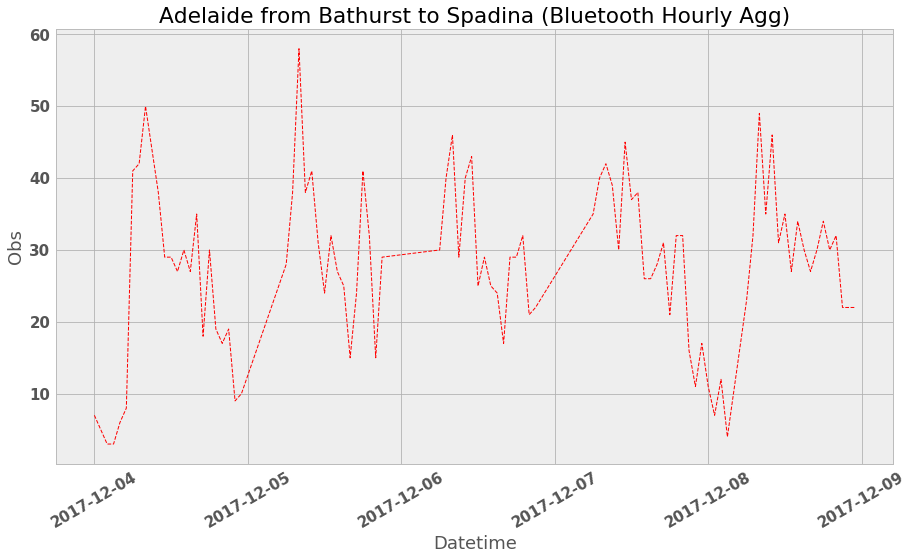

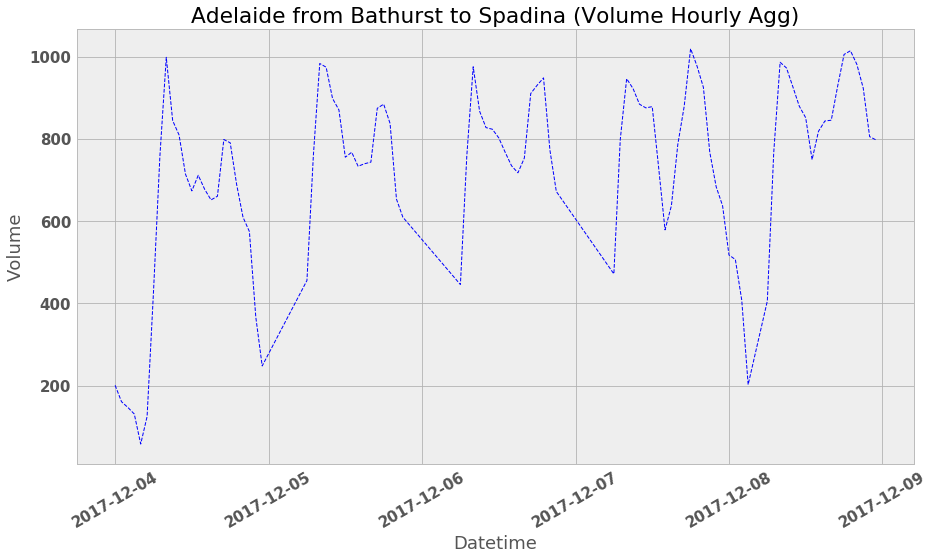

In [85]:
plt.figure(figsize = (15,8))
plt.plot(adelaide['datetime_bin'], adelaide['obs'],'r--')
plt.title('Adelaide from Bathurst to Spadina (Bluetooth Hourly Agg)')
plt.xlabel('Datetime')
plt.ylabel('Obs')
plt.rc('font', **font)
plt.xticks(rotation = 30)

plt.figure(figsize = (15,8))
plt.plot(adelaide['datetime_bin'], adelaide['volume'], 'b--')
plt.title('Adelaide from Bathurst to Spadina (Volume Hourly Agg)')
plt.xlabel('Datetime')
plt.ylabel('Volume')
plt.rc('font', **font)
plt.xticks(rotation = 30)

plt.show()

We perform a regression following the same formula. Our R squared value is even better than hourly aggregation for front st. Moroever, the scale factor is quite large being 24.36, presumably because of more traffic on Adelaide than Front St. 

In [82]:
fit = ols("volume ~ obs+0", data=adelaide).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 volume   R-squared:                       0.927
Model:                            OLS   Adj. R-squared:                  0.926
Method:                 Least Squares   F-statistic:                     1210.
Date:                Tue, 06 Feb 2018   Prob (F-statistic):           7.49e-56
Time:                        10:25:44   Log-Likelihood:                -647.30
No. Observations:                  96   AIC:                             1297.
Df Residuals:                      95   BIC:                             1299.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
obs           24.3593      0.700     34.788      0.000      22.969      25.749
==============================================================================
Omnibus:                        2.510   Durbin-Watson:                   0.968
Prob(Omnibus):                  0.285   Jarque-Bera (JB):                2.129
Skew:                          -0.363   Prob(JB):                        0.345
Kurtosis:                       3.072   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We perform our regression following the same formula as before.

C:\Users\alouis2\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\font_manager.py:1316: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


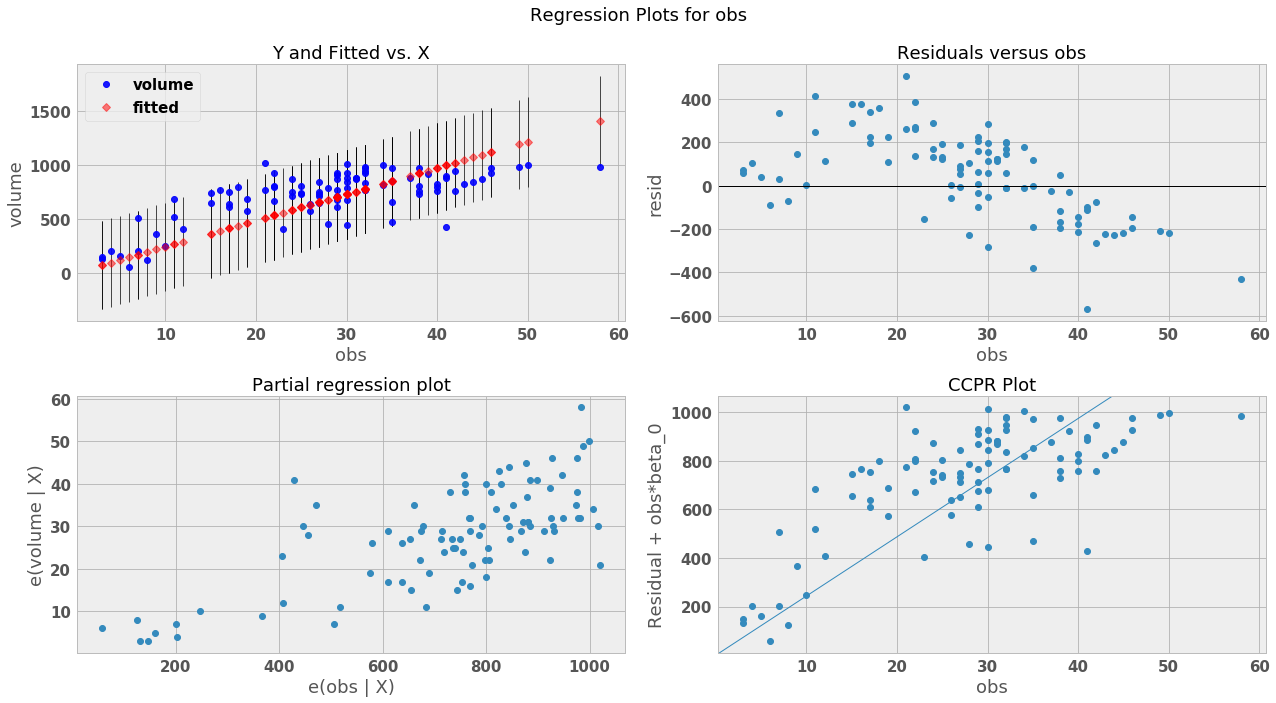

In [83]:
fig = plt.figure(figsize=(18,10))
fig = sm.graphics.plot_regress_exog(fit, "obs", fig=fig)
plt.show()

With Adelaide, we run into the same issue despite there being more large data values. As bluetooth observation values get larger, our scaling factor becomes poorer and poorer as a predictor. 